In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_met
import glob
import metpy
from metpy import calc
from metpy.units import units
from scipy import stats
import metpy
from metpy import calc
from metpy.units import units
import pickle as pkl

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
ml = 0.5
regions = {
'equatorial' : [(-5,0),(-78.25+ml, -73.75)],
'transition' : [(-8,-5), (-77.25+ml, -72.75)],
'central' : [(-12,-8), (-75.5+ml, -71.0)],
'southern' : [(-18,-15),  (-66.25+ml, -61.75)]}
h = 2000

In [4]:
ml = 0.5
lonsample=[(-78.25+ml, -73.75), (-77.25+ml, -72.75), (-75.5+ml, -71.0), (-66.25+ml, -61.75)]

In [5]:
topo_full = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/ERA5_static_hourly_0.25deg_peru.nc')
topo_full = uda.flip_lat(topo_full)

In [6]:
topo_full['z']

<xarray.DataArray 'z' (time: 1, latitude: 77, longitude: 101)>
array([[[ 4.978516e+00, -1.687500e+00, ...,  9.707246e+02,  9.788711e+02],
        [ 1.275391e+00, -6.871094e+00, ...,  9.973867e+02,  1.008496e+03],
        ...,
        [-1.687500e+00,  1.275391e+00, ...,  2.625973e+03,  2.360096e+03],
        [ 5.351562e-01, -1.057422e+01, ...,  2.734102e+03,  2.473408e+03]]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -57.5 -57.25 -57.0
  * latitude   (latitude) float32 -18.0 -17.75 -17.5 -17.25 ... 0.5 0.75 1.0
  * time       (time) datetime64[ns] 2019-08-28T12:00:00
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

In [7]:
height = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/topo_ERA5_peru.nc')['h']


In [8]:
def read(ds, region, hh = 3000):
    
    alls = regions[region]
    hei = height.sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(alls[1][0], alls[1][1]))
    zei = zz.sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(alls[1][0], alls[1][1]))

    ds_filtered = ds.sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(alls[1][0], alls[1][1])).where(hei<hh)
    
    return ds_filtered

In [9]:
def read_precip(ds, region, hh = 3000):
    
    alls = regions[region]
    hei = height.sel(latitude=slice(alls[0][0], alls[0][1]))
    zei = zz.sel(latitude=slice(alls[0][0], alls[0][1]))

    ds_filtered = ds.sel(latitude=slice(alls[0][0], alls[0][1])).where(hei>hh)
    
    return ds_filtered

In [10]:
def readERA(var):
    
    print('Opening', glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-*_peru*.nc')[0])
    u200orig = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-*_peru*.nc')[0])
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [11]:
maps = readERA('v850')
maps = maps.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/v850_15UTC_1981-2019_peru_big.nc


In [12]:
mapsu = readERA('u550')
mapsu = mapsu.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/u550_15UTC_1981-2019_peru_big.nc


In [13]:
mapsq = readERA('q850')
mapsq = mapsq.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/q850_15UTC_1981-2019_peru_big.nc


In [14]:
mapsu2 = readERA('u250')
mapsu2 = mapsu2.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/u250_15UTC_1981-2018_peru_big.nc


In [15]:
mapsv2 = readERA('v250')
mapsv2 = mapsv2.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/v250_15UTC_1981-2018_peru_big.nc


In [16]:
mapsq6 = readERA('q550')
mapsq6 = mapsq6.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/q550_15UTC_1981-2019_peru_big.nc


In [17]:
mapsdiv = readERA('d200')
mapsdiv = mapsdiv.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/d200_15UTC_1981-2018_peru.nc


In [18]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-81,-55), lat=slice(-25,0))
height = mapsq6.salem.lookup_transform(topo)
zz = mapsq6.salem.lookup_transform(topo_full['z'])


In [19]:
mcs = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/CHIRPS/SA_daily_onERA/CHIRPS_daily_onERA_*.nc')

In [20]:
#tir = mcs['tir'].sel(time=((mcs['time.year']>=1985)&(mcs['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-58)).load()
tir = mcs['precip'].sel(time=((mcs['time.year']>=1985)&(mcs['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-58)).load()

In [21]:
def corr(a, b, bsingle=None, c_box=None):
    ds = xr.Dataset()
    ds['pval'] = a.copy(deep=True).sum('time') * np.nan
    ds['r'] = a.copy(deep=True).sum('time') * np.nan
    ds['slope'] = a.copy(deep=True).sum('time') * np.nan

    corr_box = c_box

    if bsingle:
        bb = b
    else:
        bb = b.sel(latitude=slice(corr_box[2], corr_box[3]), longitude=slice(corr_box[0], corr_box[1])).mean(dim=['latitude', 'longitude'])

    for lat in a.latitude.values:
        for lon in a.longitude.values:
            #print('latlon', lat, lon)
            aa = a.sel(latitude=lat, longitude=lon)
            pf, intercept, r, p, std_err = stats.linregress(aa.values, bb.values)

            slope = pf#[0]

#             if (np.nansum(aa.values == 0) >= 10):
#                 p = np.nan
#                 r = np.nan

            ds['r'].loc[{'latitude': lat, 'longitude': lon}] = r
            ds['pval'].loc[{'latitude': lat, 'longitude': lon}] = p
            ds['slope'].loc[{'latitude': lat, 'longitude': lon}] = slope
            #ds['intercept'].loc[{'latitude': lat, 'longitude': lon}] = intercept

    return ds

In [22]:
def apply_drywet(ds, ts, region, spell=5, minus='0days', plus='0days', area=0.15):
    dwspells = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+region+"_dw_spellDates_"+str(area)+"perc_v2.p", "rb"))

    #dds = dwspells['dry'+str(spell)] -pd.Timedelta(minus) + pd.Timedelta(plus)
    wds = dwspells['wet'+str(spell)] -pd.Timedelta(minus) + pd.Timedelta(plus)
    
    #dd_true = dwspells['dry'+str(spell)] #-pd.Timedelta(minus) + pd.Timedelta(plus)
    wd_true = dwspells['wet'+str(spell)] #-pd.Timedelta(minus) + pd.Timedelta(plus)
    
   # print('dry', len(dds), 'wet', len(wds))
    print('wet', len(wds), len(wd_true))
   # xy, x_ind, y_ind  = np.intersect1d(dds, ds.time, return_indices=True)
    #dds = dds[x_ind]
    
    xy, x_ind, y_ind  = np.intersect1d(wds, ds.time, return_indices=True)
    wds = wds[x_ind]
    wd_true = wd_true[x_ind]
    print('wet2', len(wds), len(wd_true))

    #all_dry = ds.sel(time=dds)
    all_wet = ds.sel(time=wds)
    
    #ts_dry = ts.sel(time=dd_true)
    ts_wet = ts.sel(time=wd_true)
    print('Entering corr calc')
    wcorr = corr(all_wet, ts_wet, bsingle=True)
    return wcorr

In [23]:
def apply_simple(ds, region, spell=5, minus='0days', plus='0days', area=0.15):
    dwspells = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+region+"_dw_spellDates_"+str(area)+"perc_v2.p", "rb"))

    #dds = dwspells['dry'+str(spell)] -pd.Timedelta(minus) + pd.Timedelta(plus)
    wds = dwspells['wet'+str(spell)] -pd.Timedelta(minus) + pd.Timedelta(plus)
    
    #dd_true = dwspells['dry'+str(spell)] #-pd.Timedelta(minus) + pd.Timedelta(plus)
    wd_true = dwspells['wet'+str(spell)] #-pd.Timedelta(minus) + pd.Timedelta(plus)
    
   # print('dry', len(dds), 'wet', len(wds))
    print('wet', len(wds))
   # xy, x_ind, y_ind  = np.intersect1d(dds, ds.time, return_indices=True)
    #dds = dds[x_ind]
    
    xy, x_ind, y_ind  = np.intersect1d(wds, ds.time, return_indices=True)
    wds = wds[x_ind]
    wd_true = wd_true[x_ind]
    print('wet2', len(wds))

    #all_dry = ds.sel(time=dds)
    all_wet = ds.sel(time=wds).mean('time')
    
    return all_wet

In [24]:
def apply_diff(ds, region, spell=5, minus='0days', plus='0days', area=0.15):
    dwspells = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+region+"_dw_spellDates_"+str(area)+"perc_v2.p", "rb"))

    #dds = dwspells['dry'+str(spell)] -pd.Timedelta(minus) + pd.Timedelta(plus)
    wds = dwspells['wet'+str(spell)] -pd.Timedelta(minus) + pd.Timedelta(plus)
    
    #dd_true = dwspells['dry'+str(spell)] #-pd.Timedelta(minus) + pd.Timedelta(plus)
    wd_true = dwspells['wet'+str(spell)] #-pd.Timedelta(minus) + pd.Timedelta(plus)
    
   # print('dry', len(dds), 'wet', len(wds))
    print('wet', len(wds))
   # xy, x_ind, y_ind  = np.intersect1d(dds, ds.time, return_indices=True)
    #dds = dds[x_ind]
    
    xy, x_ind, y_ind  = np.intersect1d(wds, ds.time, return_indices=True)
    wds = wds[x_ind]
    wd_true = wd_true[x_ind]
    print('wet2', len(wds))

    #all_dry = ds.sel(time=dds)
    all_wet = ds.sel(time=wds).mean('time') - ds.sel(time=wd_true).mean('time')
    
    return all_wet

In [360]:
# q550 only

reg_tag = 'equatorial'

mapsq6_southern = read(mapsq6['q550'], reg_tag, hh=3000)
mapsq6_ts = mapsq6_southern.mean(['latitude','longitude'])

spelldays=5
ar=0.15

series = []
for num in np.arange(0,5)[::-1]:
    series.append(apply_drywet(mapsq6['q550'], mapsq6_ts, reg_tag, spell=spelldays, minus=str(num)+'days', plus='0days', area=ar))
for num in np.arange(1,6):
    series.append(apply_drywet(mapsq6['q550'], mapsq6_ts, reg_tag, spell=spelldays, minus='0days', plus=str(num)+'days', area=ar))

wet 642 642
wet2 642 642
Entering corr calc
wet 642 642
wet2 642 642
Entering corr calc
wet 642 642
wet2 642 642
Entering corr calc
wet 642 642
wet2 642 642
Entering corr calc
wet 642 642
wet2 642 642
Entering corr calc
wet 642 642
wet2 642 642
Entering corr calc
wet 642 642
wet2 642 642
Entering corr calc
wet 642 642
wet2 642 642
Entering corr calc
wet 642 642
wet2 642 642
Entering corr calc
wet 642 642
wet2 642 642
Entering corr calc


In [286]:
# # u box vs divergence

# reg_tag = 'central'

# mapsq6_southern = read(mapsu2['u'], reg_tag, hh=3000)
# mapsq6_ts = mapsq6_southern.mean(['latitude','longitude'])

# spelldays=5
# ar=0.15

# series = []
# for num in np.arange(0,5)[::-1]:
#     series.append(apply_drywet(mapsu['u550'], mapsq6_ts, reg_tag, spell=spelldays, minus=str(num)+'days', plus='0days', area=ar))
# for num in np.arange(1,6):
#     series.append(apply_drywet(mapsu['u550'], mapsq6_ts, reg_tag, spell=spelldays, minus='0days', plus=str(num)+'days', area=ar))

In [25]:
reg_tag = 'transition'

In [350]:
# # rain vs q550

# reg_tag = 'central'

# mapsq6_southern = read_precip(tir, reg_tag, hh=2000)
# mapsq6_ts = mapsq6_southern.mean(['latitude','longitude'])

# spelldays=5
# ar=0.15

# series = []
# for num in np.arange(0,5)[::-1]:
#     series.append(apply_drywet(mapsq['q'], mapsq6_ts, reg_tag, spell=spelldays, minus=str(num)+'days', plus='0days', area=ar))
# for num in np.arange(1,6):
#     series.append(apply_drywet(mapsq['q'], mapsq6_ts, reg_tag, spell=spelldays, minus='0days', plus=str(num)+'days', area=ar))

In [361]:
# seriesu = []
# for num in np.arange(0,5)[::-1]:
#     seriesu.append(apply_simple(mapsu2['u'], reg_tag, spell=spelldays, minus=str(num)+'days', plus='0days', area=ar))
# for num in np.arange(1,6):
#     seriesu.append(apply_simple(mapsu2['u'], reg_tag, spell=spelldays, minus='0days', plus=str(num)+'days', area=ar))

wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642


In [26]:
# seriesp = []
# for num in np.arange(0,5)[::-1]:
#     seriesp.append(apply_simple(tir, reg_tag, spell=spelldays, minus=str(num)+'days', plus='0days', area=ar))
# for num in np.arange(1,6):
#     seriesp.append(apply_simple(tir, reg_tag, spell=spelldays, minus='0days', plus=str(num)+'days', area=ar))

NameError: name 'spelldays' is not defined

In [363]:
# seriesv8 = []
# seriesu8 = []
# for num in np.arange(0,5)[::-1]:
#     seriesv8.append(apply_simple(mapsv2['v'], reg_tag, spell=spelldays, minus=str(num)+'days', plus='0days', area=ar))
#     seriesu8.append(apply_simple(mapsu2['u'], reg_tag, spell=spelldays, minus=str(num)+'days', plus='0days', area=ar))
# for num in np.arange(1,6):
#     seriesv8.append(apply_simple(mapsv2['v'], reg_tag, spell=spelldays, minus=str(num)+'days', plus='0days', area=ar))
#     seriesu8.append(apply_simple(mapsu2['u'], reg_tag, spell=spelldays, minus='0days', plus=str(num)+'days', area=ar))

wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642


In [364]:
# seriesq = []
# seriesq = []
# for num in np.arange(0,5)[::-1]:
#     seriesq.append(apply_simple(maps['v'], reg_tag, spell=spelldays, minus=str(num)+'days', plus='0days', area=ar))
# for num in np.arange(1,6):
#     seriesq.append(apply_simple(maps['v'], reg_tag, spell=spelldays, minus='0days', plus=str(num)+'days', area=ar))

wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642
wet 642
wet2 642


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: No contour levels were found within the data range.


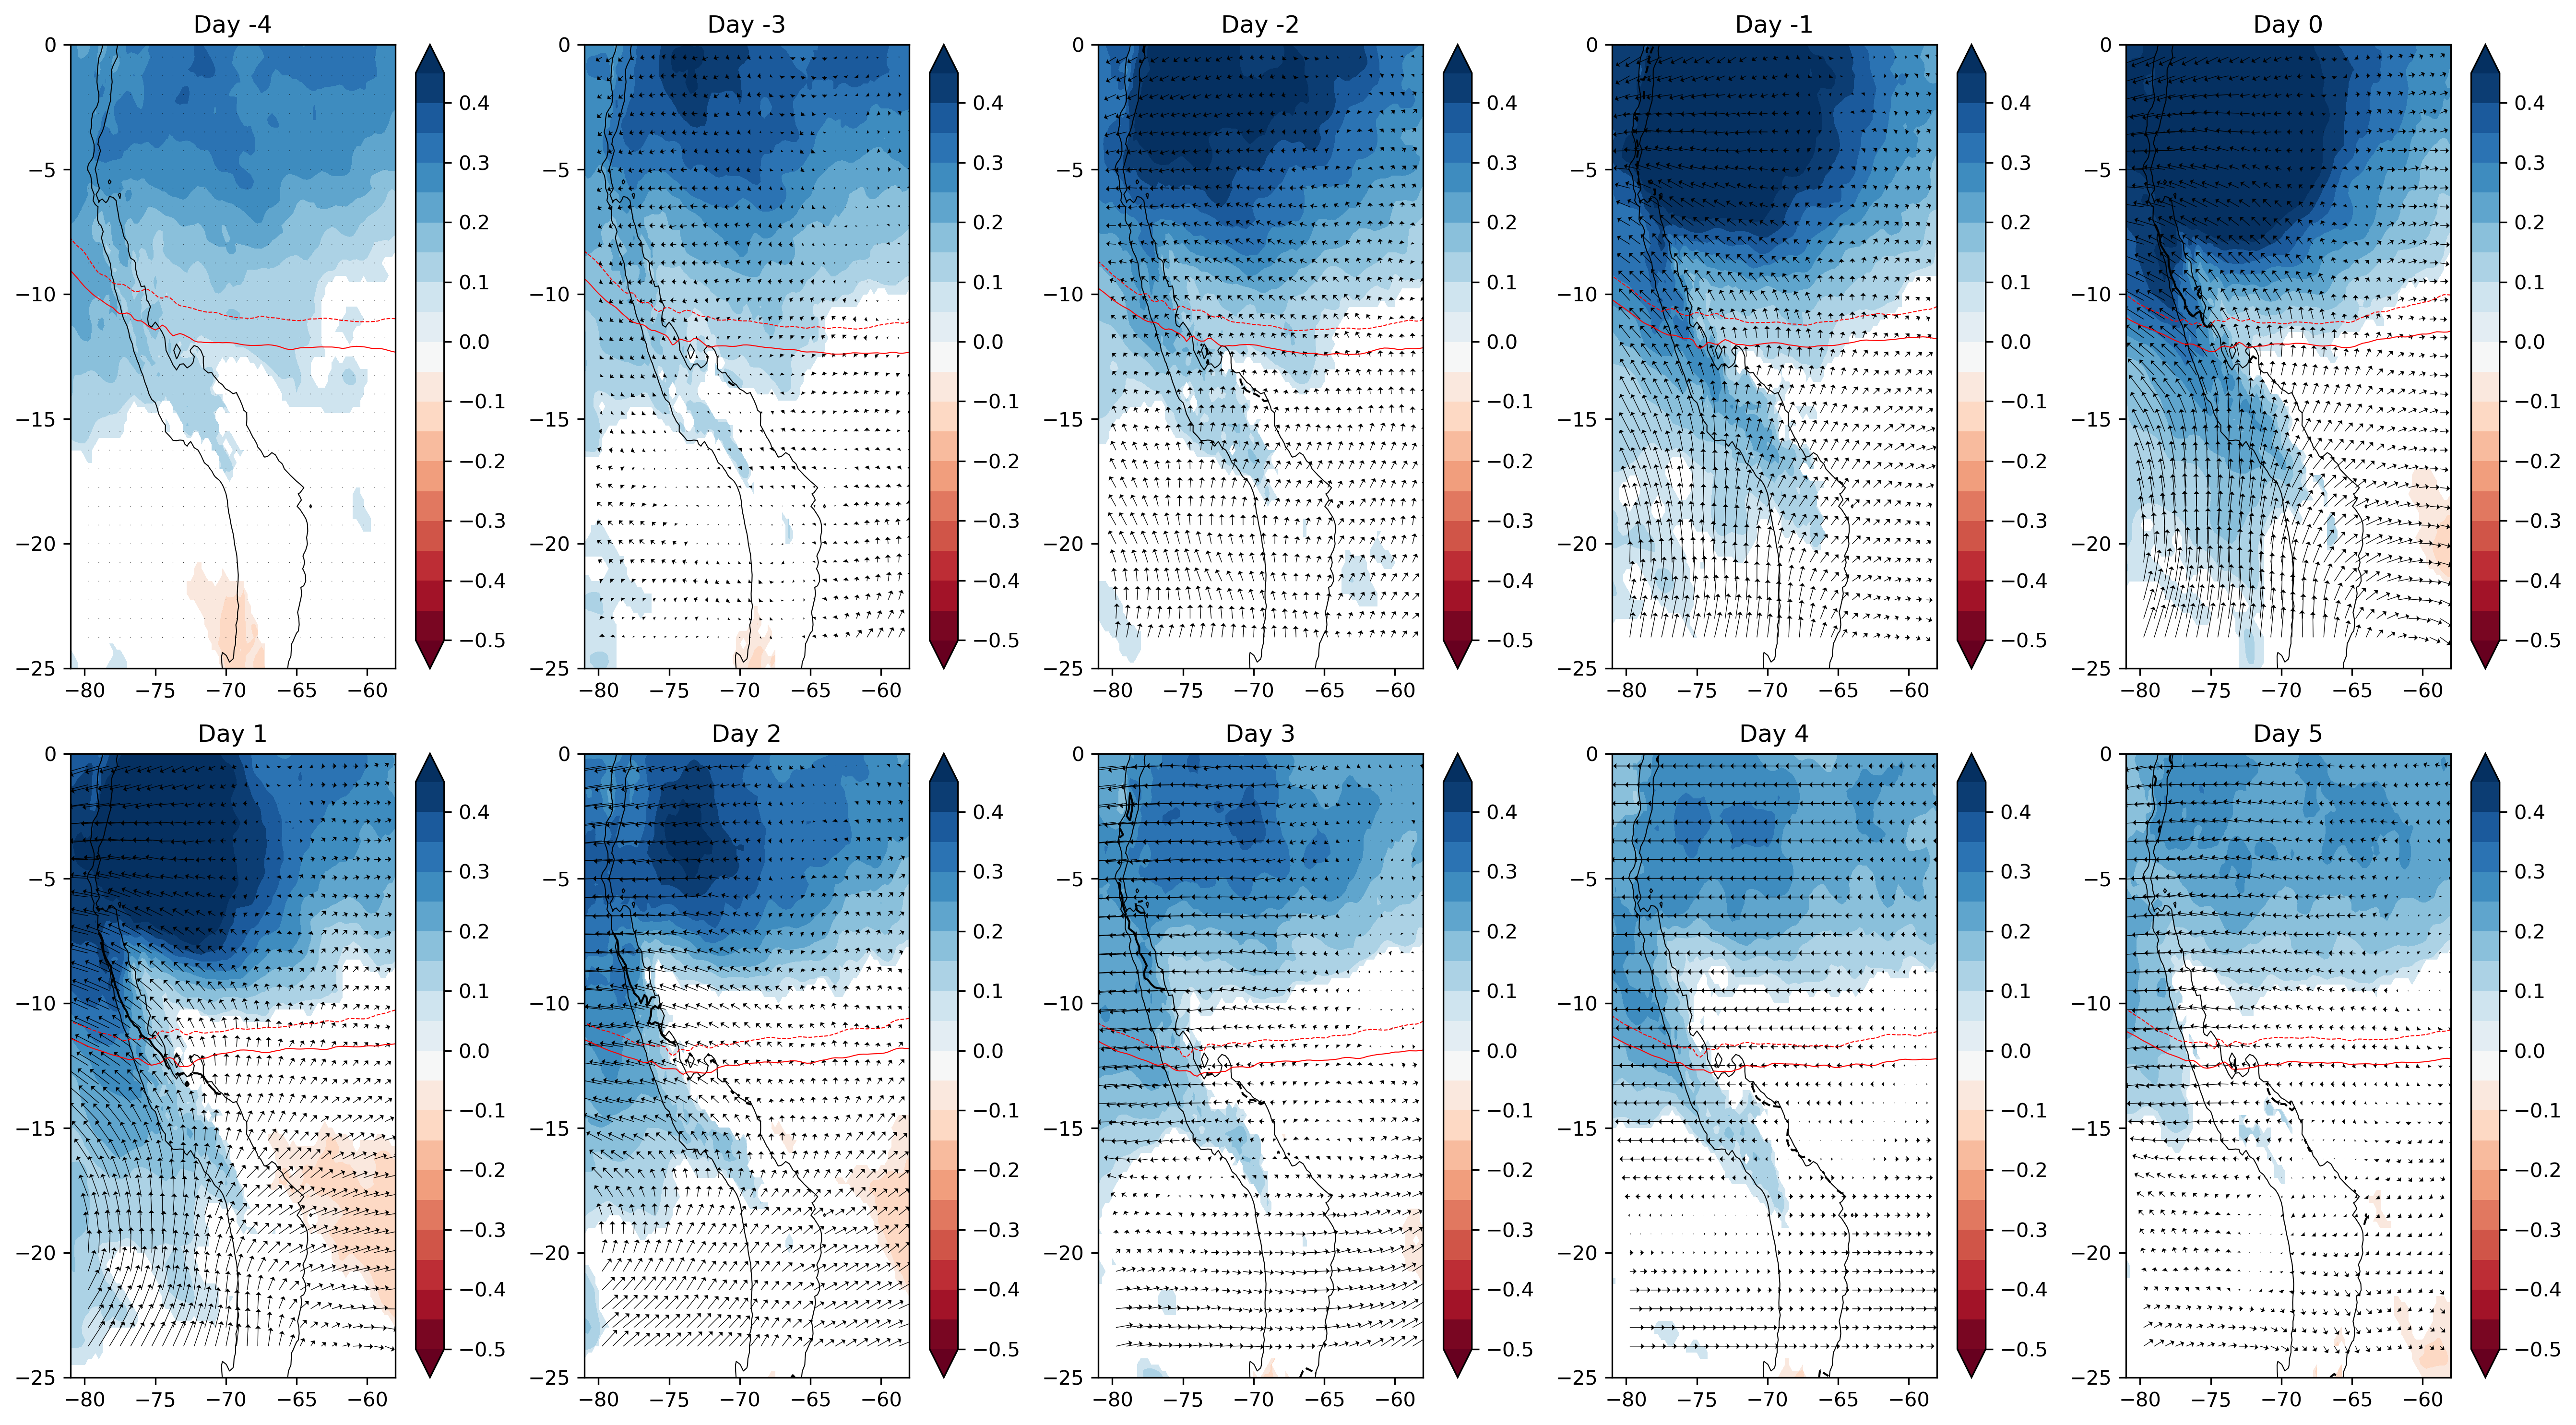

In [369]:
f = plt.figure(figsize=(18,10), dpi=300)

count = np.arange(-4, 6)

for ids in np.arange(len(series)):
    
    ax = f.add_subplot(2,5,ids+1)
    
    st=3
    sarrow = 5
    xquiv = seriesu8[ids].longitude[sarrow::st]
    yquiv = seriesv8[ids].latitude[sarrow::st]

    uud = ((seriesu8[ids].values)-(seriesu8[0].values))[sarrow::st, sarrow::st]  
    vvd = ((seriesv8[ids].values)-(seriesv8[0].values))[sarrow::st, sarrow::st]
    
    mp = ax.contourf(series[ids].longitude, series[ids].latitude, series[ids]['r'].where(series[ids]['pval']<=0.05), levels=np.arange(-0.5,0.5,0.05), cmap='RdBu', extend='both')
    #mp = ax.contourf(series[ids].longitude, series[ids].latitude, seriespcorr[ids]['r'].where(seriespcorr[ids]['pval']<=0.05), levels=np.arange(-0.5,0.5,0.05), cmap='RdBu', extend='both')
    #mp = ax.contourf(seriesq[ids].longitude, seriesq[ids].latitude, (seriesq[ids]-seriesq[0]), levels=np.arange(-1,1,0.1), cmap='RdBu', extend='both')
    plt.colorbar(mp)
    ax.contour(seriesu8[ids].longitude, seriesu8[ids].latitude, height, levels=[-50,2000], colors='k', linewidths=0.5)
    
    ax.contour(seriesu8[ids].longitude, seriesu8[ids].latitude, seriesu[ids], levels=[-1,0.1], colors='r', linewidths=0.5)
    
    ax.contour(seriesu8[ids].longitude, seriesu8[ids].latitude, seriesp[ids].where(height>1500)-seriesp[0].where(height>1500), levels=[-1,1], colors='k', linewidths=1)
    
    
    plt.quiver(xquiv, yquiv, uud, vvd, scale=30, width=0.002, headwidth=9)
    
    plt.title('Day '+str(count[ids]))
    plt.tight_layout()
    f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/q550_correlation_progression_uv250_'+reg_tag+'.jpg')

In [33]:
reg_tag = 'central'
## rain only
mapsq6_southern = read_precip(tir, reg_tag, hh=2000)
mapsq6_ts = mapsq6_southern.mean(['latitude','longitude'])

spelldays=5
ar=0.15

seriespcorr = []
for num in np.arange(0,5)[::-1]:
    seriespcorr.append(apply_drywet(tir, mapsq6_ts, reg_tag, spell=spelldays, minus=str(num)+'days', plus='0days', area=ar))
for num in np.arange(1,6):
    seriespcorr.append(apply_drywet(tir, mapsq6_ts, reg_tag, spell=spelldays, minus='0days', plus=str(num)+'days', area=ar))

wet 714 714
wet2 713 713
Entering corr calc
wet 714 714
wet2 713 713
Entering corr calc
wet 714 714
wet2 713 713
Entering corr calc
wet 714 714
wet2 713 713
Entering corr calc
wet 714 714
wet2 714 714
Entering corr calc
wet 714 714
wet2 714 714
Entering corr calc
wet 714 714
wet2 714 714
Entering corr calc
wet 714 714
wet2 714 714
Entering corr calc
wet 714 714
wet2 713 713
Entering corr calc
wet 714 714
wet2 713 713
Entering corr calc


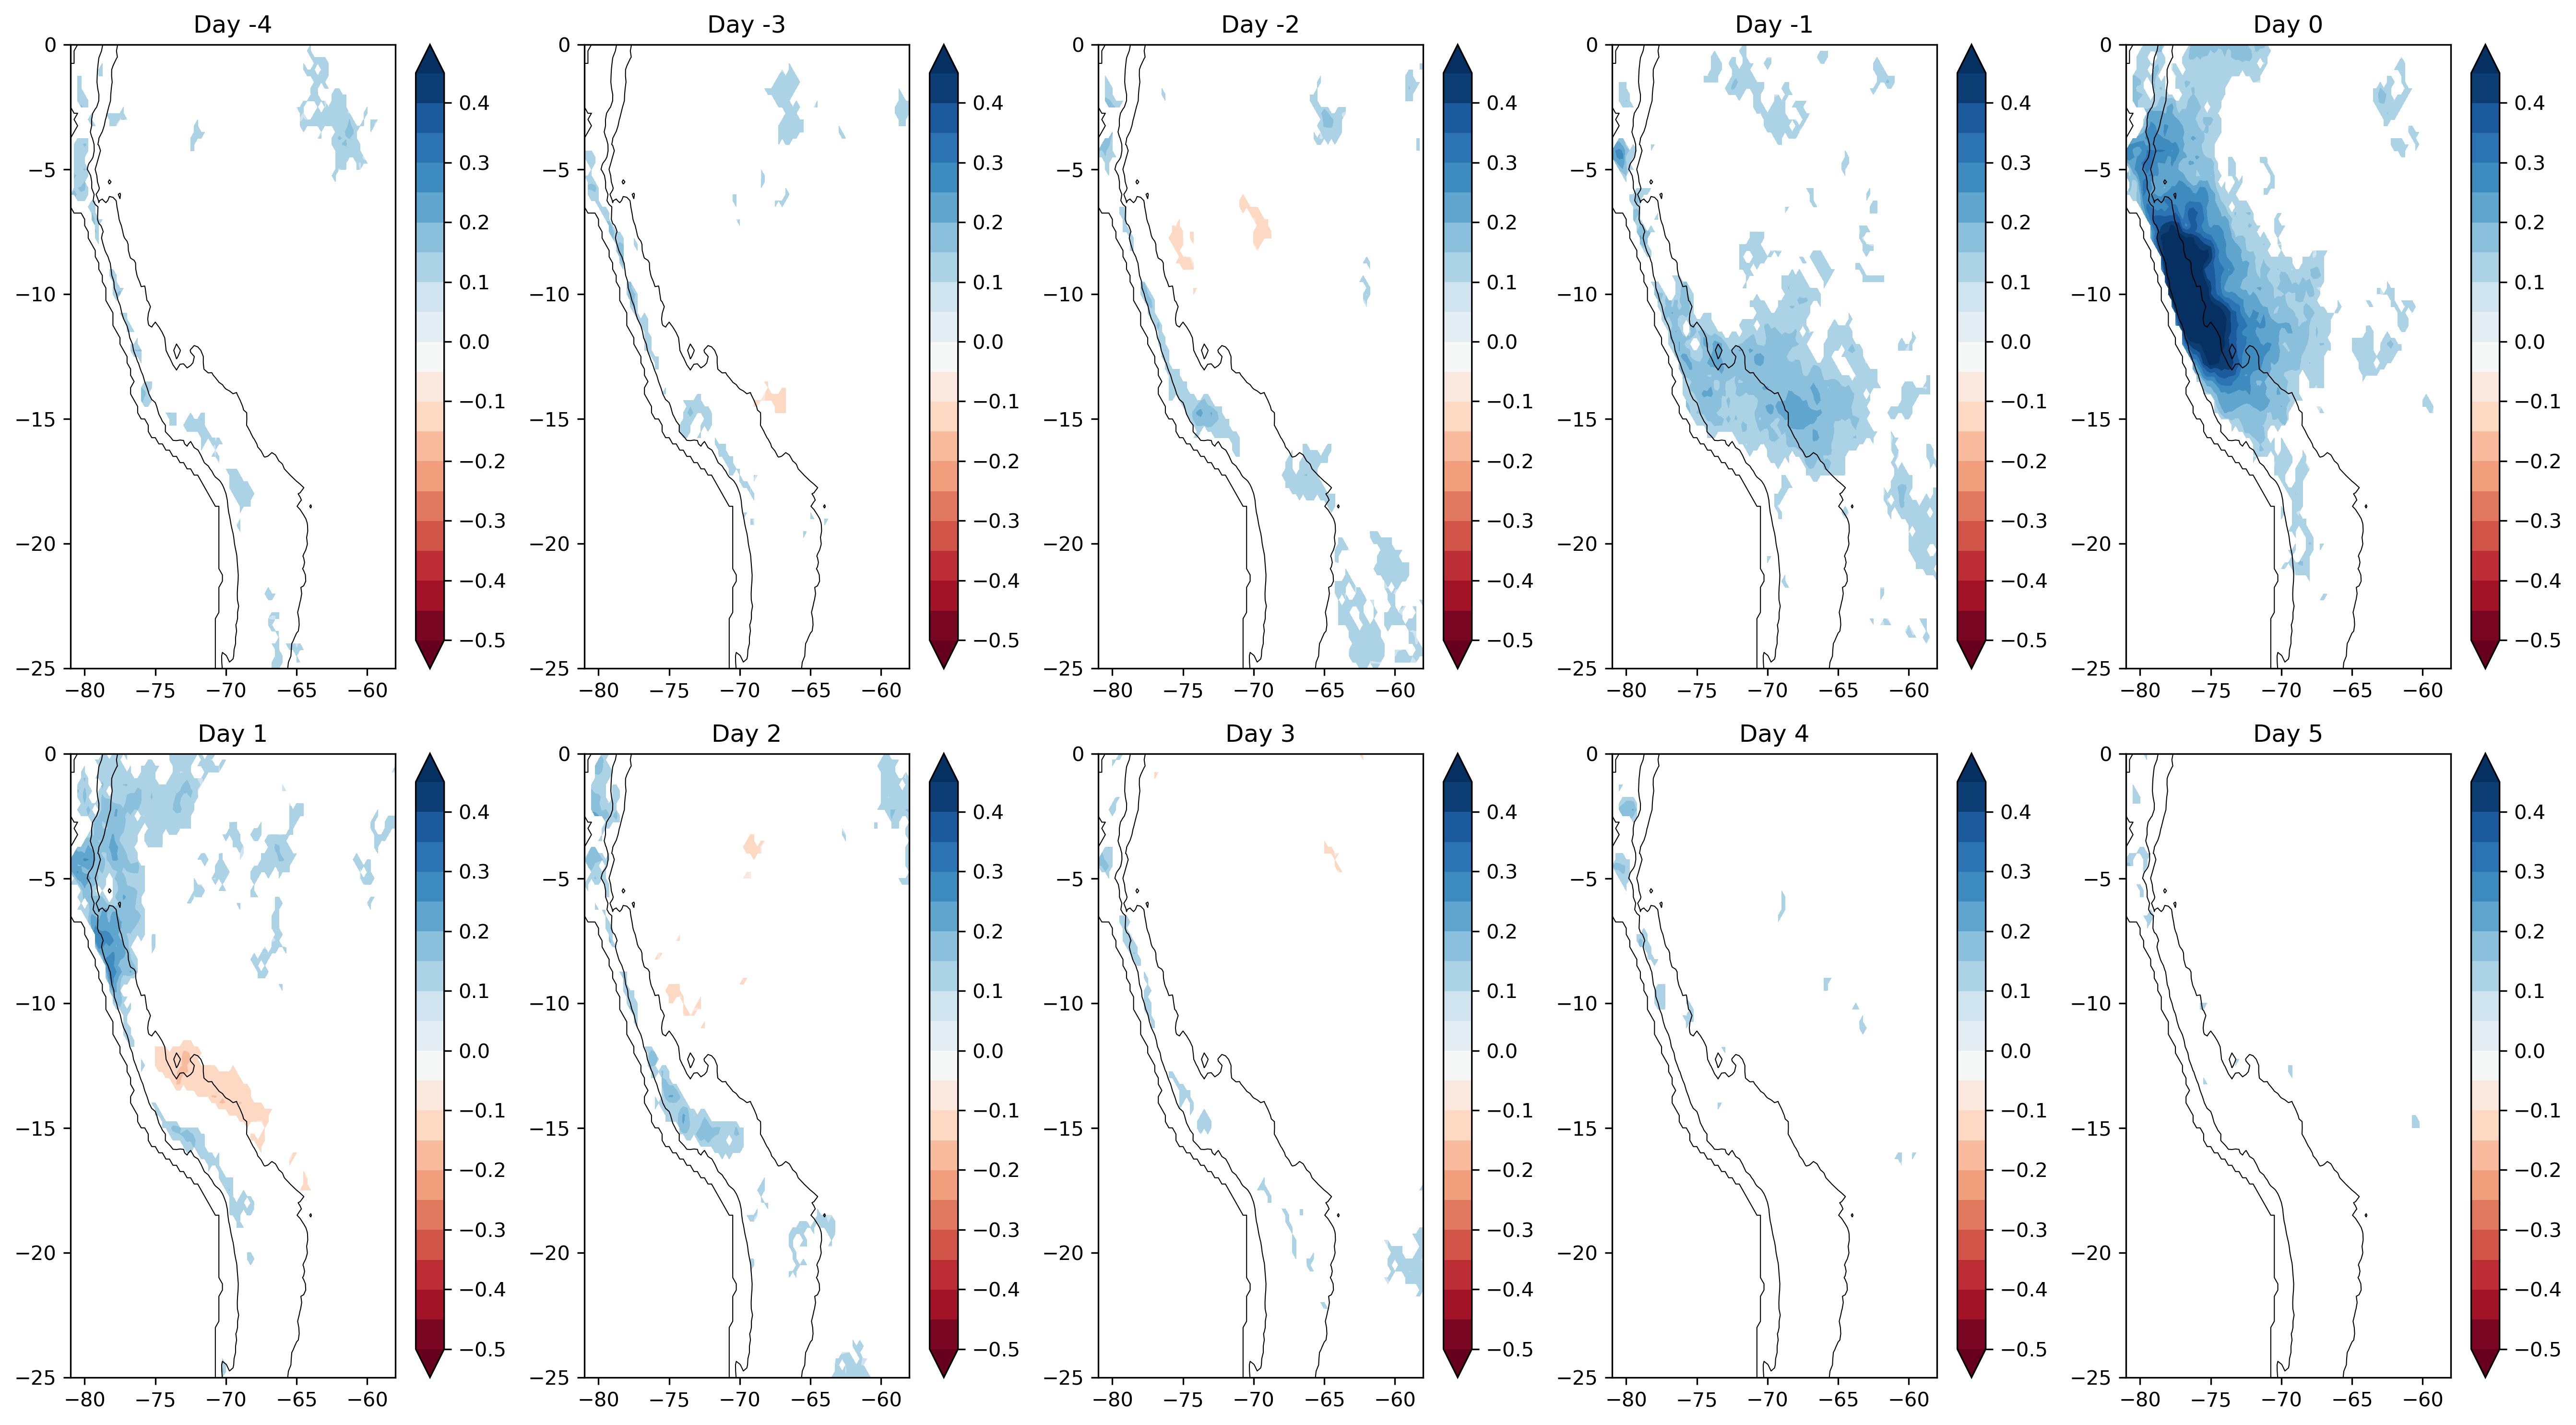

In [34]:
f = plt.figure(figsize=(18,10), dpi=300)

count = np.arange(-4, 6)

for ids in np.arange(len(seriespcorr)):
    
    ax = f.add_subplot(2,5,ids+1)

    mp = ax.contourf(seriespcorr[ids].longitude, seriespcorr[ids].latitude, seriespcorr[ids]['r'].where(seriespcorr[ids]['pval']<=0.01), levels=np.arange(-0.5,0.5,0.05), cmap='RdBu', extend='both')
    ax.contour(seriespcorr[ids].longitude, seriespcorr[ids].latitude, height, levels=[-50, 0,2000], colors='k', linewidths=0.5)
    plt.colorbar(mp)

    plt.title('Day '+str(count[ids]))
    plt.tight_layout()
    f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/prcp_correlation_progression_only_'+reg_tag+'.jpg')